In [38]:
pip install bs4

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


In [40]:
pip install shapely


Note: you may need to restart the kernel to use updated packages.


In [41]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [42]:
import requests
import lxml.html as lh
import bs4 as bs
import urllib.request
import numpy as np 
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

In [43]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
res = requests.get(url)
soup = bs.BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
data = pd.read_json(df[0].to_json(orient='records'))

In [44]:
data.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [45]:
raw_data_selected = data[data['Borough'] != 'Not assigned']

In [46]:
raw_data_selected = raw_data_selected.groupby(['Borough', 'Postal Code'], as_index=False).agg(','.join)

In [47]:
raw_data_selected.head()

,Borough,Postal Code,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


In [48]:
raw_data_selected['Neighbourhood'] = np.where(raw_data_selected['Neighbourhood'] == 'Not assigned', raw_data_selected['Borough'], raw_data_selected['Neighbourhood'])

In [49]:
raw_data_selected.shape

(103, 3)

In [50]:
geospatial_url = "https://cocl.us/Geospatial_data"
geospatial_data = pd.read_csv(geospatial_url)

In [51]:
geospatial_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [52]:
geospatial_data.columns = ['Postal Code', 'Latitude', 'Longitude']

In [53]:
geospatial_data.columns

Index(['Postal Code', 'Latitude', 'Longitude'], dtype='object')

In [54]:
merged_data = pd.merge(raw_data_selected, geospatial_data, on='Postal Code')


In [55]:
merged_data.head(12)


,Borough,Postal Code,Neighbourhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160
5,Central Toronto,M4V,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049
6,Central Toronto,M5N,Roselawn,43.711695,-79.416936
7,Central Toronto,M5P,"Forest Hill North & West, Forest Hill Road Park",43.696948,-79.411307
8,Central Toronto,M5R,"The Annex, North Midtown, Yorkville",43.672710,-79.405678
9,Downtown Toronto,M4W,Rosedale,43.679563,-79.377529


In [56]:
merged_data['Coordinates'] = list(zip(merged_data['Latitude'], merged_data['Longitude']))


In [57]:
merged_data.head()

,Borough,Postal Code,Neighbourhood,Latitude,Longitude,Coordinates
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,"(43.7280205, -79.3887901)"
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,"(43.7127511, -79.3901975)"
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678,"(43.7153834, -79.40567840000001)"
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,"(43.7043244, -79.3887901)"
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160,"(43.6895743, -79.38315990000001)"


In [58]:
merged_data['Coordinates'] = merged_data['Coordinates'].apply(Point)

In [59]:
gdf = gpd.GeoDataFrame(merged_data, geometry='Coordinates')


In [60]:
gdf.head()

,Borough,Postal Code,Neighbourhood,Latitude,Longitude,Coordinates
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,POINT (43.72802 -79.38879)
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,POINT (43.71275 -79.39020)
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678,POINT (43.71538 -79.40568)
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,POINT (43.70432 -79.38879)
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160,POINT (43.68957 -79.38316)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


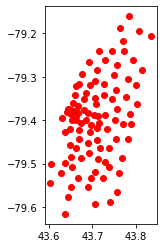

In [61]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
ax = cities[cities.name == "Toronto"].plot(
    color='green', edgecolor='black')

gdf.plot(ax=ax, color='red')

plt.show()

In [62]:
gdf.shape

(103, 6)